# McCabe-Thiele Diagram Code

In [4]:
import numpy as np
import matplotlib.pyplot as plt

###########################################################################

#Kurva kesetimbangan (awal)
def eq_kk(xa, rv):               #rv = relative volatility
    ya = (rv*xa)/(1+(rv-1)*xa)   #Raoult and Dalton's Law
    return ya

#Kurva Kesetimbangan (accounting for system's Murphree Efficiency)
def eq_nm(xa,rv,nm):
    ya = (rv*xa)/(1+(rv-1)*xa)
    ya = ((ya-xa)*nm)+xa
    return ya

def eq2_nm(ya,rv,nm):
    '''
    inverse of eq_nm takes form of a quadratic             
    The inverse is: xa = ((rv*xa)/(1+(rv-1)*xa))x^2 + (((ya-xa)*nm) + xa)x +  ya
                                   ax^2                        bx             c
    Maka,
    '''
    a  = ((rv*nm)-nm-rv+1)
    b  = ((ya*rv)-ya+nm-1-(rv*nm))
    c  = ya
    xa = (-b-np.sqrt((b**2)-(4*a*c)))/(2*a)
    return xa

###########################################################################

#Top Operating Line (TOL)
def stepping_TOL(x1,y1,rv,R,xd): 
    x2 = eq2_nm(y1,rv,nm)
    y2 = (((R*x2)/(R+1))+(xd/(R+1)))     #Persamaan TOL
    return x1,x2,y1,y2

#Bottom Operating Line (BOL)
def stepping_BOL(x1,y1,rv,TOL_qx,TOL_qy,xb):
    x2 = eq2_nm(y1,rv,nm)
    m  = ((xb-TOL_qy)/(xb-TOL_qx))
    c  = TOL_qy - (m*TOL_qx)             #Intecept BOL
    y2 = (m*x2) + c
    return x1,x2,y1,y2

###########################################################################

# McCabe-Thiele Graph
def mccabethiele(Aa,Ba,Ca,Da,Ea,Ab,Bb,Cb,Db,Eb,T,xA,xB,R_factor,xf,xd,xb,q,nm):
    Pa = 10 ** (Aa + Ba / T + Ca * np.log10(T) + Da * T + Ea * (T ** 2))
    Pb = 10 ** (Ab + Bb / T + Cb * np.log10(T) + Db * T + Eb * (T ** 2))
    vap_a = Pa * xA
    vap_b = Pb * xB
    rv = vap_a / vap_b
    #Prevent Error when dividing zero
    if q==1:
        q-=0.00000001
    if q==0:
        q+=0.00000001
    xa = np.linspace(0,1,100)
    ya_kk = eq_kk(xa[:],rv)
    ya_eq = eq_nm(xa[:],rv,nm)
    
    ###########################################################################
    
    #garis diagonal
    diagonal_x = xa[:]
    diagonal_y = xa[:]
    
    #intecept between q-line and the equilibrium data
    a = ((rv*q)/(q-1))-rv+(rv*nm)-(q/(q-1))+1-nm
    b = (q/(q-1))-1+nm+((rv*xf)/(1-q))-(xf/(1-q))-(rv*nm)
    c = xf/(1-q)
    
    #intersection between q-line and KK (x-axis)
    if q>1:
            eq_qx = (-b+np.sqrt((b**2)-(4*a*c)))/(2*a)
    else:
            eq_qx = (-b-np.sqrt((b**2)-(4*a*c)))/(2*a)
    
    #intersection between q-line and Kurva Kesetimbangan (y-axis)
    eq_qy = eq_nm(eq_qx,rv,nm)
      
    #Mencari TOL pada R
    y_min = xd*(1-((xd-eq_qy)/(xd-eq_qx)))
    Rmin  = (xd/y_min)-1
    R     = R_factor*Rmin
    y_R = (xd/(R+1))
    
    #TOL yang intersep dengan q-line
    TOL_qx = ((y_R-(xf/(1-q)))/((q/(q-1))-((xd-y_R)/xd)))
    TOL_qy = (TOL_qx*((xd-y_R)/xd))+y_R
    
    ###########################################################################
    
    #Plot komponen dasar pada grafik
    plt.figure()
    plt.rcParams["figure.figsize"] = (7,7)
    plt.axis([0,1,0,1])
    plt.plot([xd,xd],[0,xd],color = 'k', linestyle='--') #garis xd
    plt.plot([xb,xb],[0,xb],color = 'k', linestyle='--') #garis xb
    plt.plot([xf,xf],[0,xf],color = 'k', linestyle='--') #garis xf
    
    #Top Operating Line pada R
    plt.plot([xd,TOL_qx],[xd,TOL_qy],color='b')
    
    #Bottom Operating Line
    plt.plot([xb,TOL_qx],[xb,TOL_qy],color='m')
    
    x1,x2,y1,y2=stepping_TOL(xd,xd,rv,R,xd)
    step_count = 1
    plt.plot([x1,x2],[y1,y1],color='r')  #step 1
    plt.plot([x2,x2],[y1,y2],color='r')  #step 2
    plt.text(x2+0.015,y1-0.045,step_count)
    while x2>TOL_qx:
        x1,x2,y1,y2=stepping_TOL(x2,y2,rv,R,xd)
        plt.plot([x1,x2],[y1,y1],color='r')
        plt.plot([x2,x2],[y1,y2],color='r')
        step_count += 1
        plt.text(x2+0.015,y2-0.045,step_count)
        
    feed_stage = step_count
    
    x1,x2,y1,y2 = stepping_BOL(x1,y1,rv,TOL_qx,TOL_qy,xb)
    plt.plot([x1,x2],[y1,y1],color='r')
    plt.plot([x2,x2],[y1,y2],color='r')
    step_count += 1
    while x2>xb:
        x1,x2,y1,y2 = stepping_BOL(x2,y2,rv,TOL_qx,TOL_qy,xb)
        plt.plot([x1,x2],[y1,y1],color='r')
        plt.plot([x2,x2],[y1,y2],color='r')
        plt.text(x2+0.015,y2-0.045,step_count)
        step_count += 1
    
    plt.plot([x2,x2],[y1,0],color='k')
    xb_actual = x2
    stages    = step_count - 1 
    plt.plot(diagonal_x,diagonal_y,color='k')     #Diagonal Line
    plt.plot(xa,ya_kk,color='k')                  #Kurva Kesetimbangan   
    plt.plot([xf,TOL_qx],[xf,TOL_qy],color='k')   #Q-line
    
    #Kurva Kesetimbangan setelah dimasukkan Murphree Efficiency
    plt.plot(xa,ya_eq,color='r',linestyle='--')
    
    ###########################################################################
    
    #Labels & Informations
    plt.xlabel('xa', fontweight='bold')
    plt.ylabel('ya', fontweight='bold')
    plt.text(0.5,0.35,'Stage= '+str(round(stages)))
    plt.text(0.5,0.3,'Feed Stage= '+str(round(feed_stage)))
    plt.text(0.5,0.25,'Rectifying Section = Blue')
    plt.text(0.5,0.2,'Stripping Section = Magenta')
    plt.title('McCabe-Thiele Graph'+'\n'+\
              '\n'+\
              'xd='+str(0.995)+\
              '   xb='+str(xb)+'\n'+\
              'zf='+str(xf)+\
              '   q='+str(round(q,3))+'\n'+\
              'Rmin= '+str(round(Rmin,1))+\
              '  R='+str(round(R,2))+'\n'+\
              'Murphree Efficiency='+str(nm))
    
    ###########################################################################
    
    #Error Percentage
    #stage_hysys = 5       #Number of stage from Hysys Calculation
    #if stages > stage_hysys:
        #acc = -(100 - (stages/stage_hysys)*100)
    #else:
        #acc = 100 - (stages/stage_hysys)*100        
    #print ('Error Percentage = ', acc, '%')

    #plt.grid(True)
    #plt.show()   
    return

# McCabe-Thiele Diagram Parameter Input

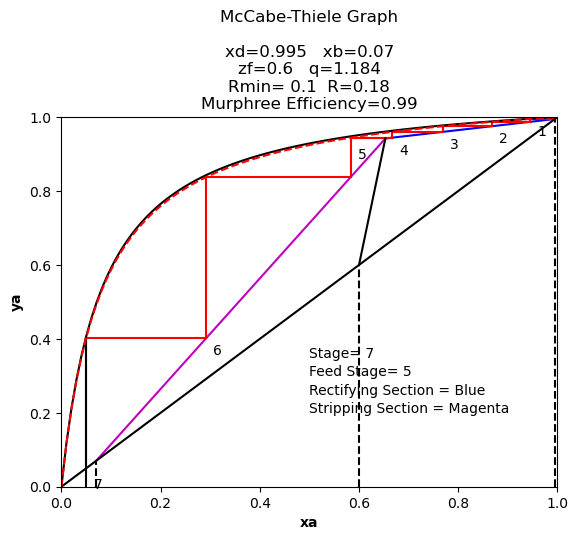

In [6]:
#Antoine Constant of Component A (The more volatile substance)
Aa = 28.588      
Ba = -2469
Ca = -7.351
Da = 2.8025E-10
Ea = 2.7361E-06

#Antoine Constant of Component B (The less volatile substance)
Ab = 28.376      
Bb = -2973.4
Cb = -7.032
Db = -1.5051E-09
Eb = 2.1806E-06

T  = 343         #T in Kelvin
xA = 0.6         #Mole fraction of substance A
xB = 0.4         #Mole fraction of substance B

xd = 0.995          # Distillate composition 
xb = 0.07           # Bottoms composition 
xf = 0.6            # Feed composition 
q  = 1.184          # mole fraction of liquid in the feed 
R_factor = 1.5      # Reflux ratio = R_min* R_factor
nm = 0.99           # Murphree Efficiency (0 < nm < 1)

mccabethiele(Aa,Ba,Ca,Da,Ea,Ab,Bb,Cb,Db,Eb,T,xA,xB,R_factor,xf,xd,xb,q,nm)